# Data Loading and Cleaning

Loads and examines the initial structure of the datasets required.

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load Data
df_adjusted = pd.read_csv('../data/combined_data_season_adjusted.csv')
df_not_adjusted = pd.read_csv('../data/combined_data_season_not_adjusted.csv')
categories = pd.read_csv('../data/code_categories.csv')

- **`df_adjusted` (*combined_data_season_adjusted*)**: Contains the main dataset with seasonally adjusted sales data for retail and food services from 2017–2023.
- 
**`df_not_adjusted` (*combined_data_season_not_adjusted*)**: Contains the main dataset with raw sales data for retail and food services from 2017–2023.
  
- **`categories` (*code_categories*)**: Provides a mapping of category codes to descriptive names, enabling a better understanding of each retail and food service segment.


In [3]:
df_adjusted.head()

,cell_value,time_slot_id,error_data,category_code,seasonally_adj,data_type_code,time,us
0,688810.0,0,no,44X72,yes,SM,2023-06,1
1,703256.0,0,no,44X72,yes,SM,2023-12,1
2,11124.0,0,no,4521E,yes,SM,2023-04,1
3,10871.0,0,no,4521E,yes,SM,2023-10,1
4,415563.0,0,no,44000,yes,SM,2017-02,1


In [4]:
categories.head()

,category_code,category_name,high_level_category
0,44X72,Retail Trade and Food Services,Retail and Food Services
1,4521E,Department Stores,Retail Trade
2,44000,Retail Trade,Retail Trade
3,444,Building Material and Garden Equipment and Sup...,Retail Trade
4,44Y72,"Retail Trade and Food Services, ex Auto",Retail and Food Services


In [5]:
df_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cell_value      3500 non-null   float64
 1   time_slot_id    3500 non-null   int64  
 2   error_data      3500 non-null   object 
 3   category_code   3500 non-null   object 
 4   seasonally_adj  3500 non-null   object 
 5   data_type_code  3500 non-null   object 
 6   time            3500 non-null   object 
 7   us              3500 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 218.9+ KB


In [6]:
pd.options.display.float_format = '{:.2f}'.format

As the dataset contains no `null` values, we proceed to examine the unique values in each column to understand the variability and structure of the data.

In [7]:
for column in df_adjusted.columns:
    print(f"Column: {column}")
    print(f"Unique values: {df_adjusted[column].unique()}")
    print(f"Number of unique values: {df_adjusted[column].nunique()}\n")

Column: cell_value
Unique values: [6.88810e+05 7.03256e+05 1.11240e+04 ... 7.60000e+00 4.80000e+00
 5.00000e+00]
Number of unique values: 1797

Column: time_slot_id
Unique values: [0]
Number of unique values: 1

Column: error_data
Unique values: ['no' 'yes']
Number of unique values: 2

Column: category_code
Unique values: ['44X72' '4521E' '44000' '444' '44Y72' '451' '453' '4451' '441' '454'
 '441X' '443' '447' '446' '452' '448' '445' '44W72' '442' '44Z72' '722']
Number of unique values: 21

Column: seasonally_adj
Unique values: ['yes']
Number of unique values: 1

Column: data_type_code
Unique values: ['SM' 'E_SM']
Number of unique values: 2

Column: time
Unique values: ['2023-06' '2023-12' '2023-04' '2023-10' '2017-02' '2017-08' '2017-10'
 '2017-01' '2017-07' '2018-09' '2019-05' '2019-11' '2020-03' '2020-09'
 '2021-02' '2021-08' '2019-02' '2019-08' '2020-06' '2020-12' '2017-06'
 '2017-12' '2017-05' '2018-01' '2018-07' '2020-11' '2020-01' '2020-07'
 '2021-03' '2021-09' '2021-01' '2021-0

Convert data types to appropriate types

 -`time` to `Datetime` format for easier analysis.

In [8]:
df_adjusted['time'] = pd.to_datetime(df_adjusted['time'], format='%Y-%m')
df_not_adjusted['time'] = pd.to_datetime(df_not_adjusted['time'], format='%Y-%m')
df_adjusted = df_adjusted.sort_values(by='time', ascending=True)
df_not_adjusted = df_not_adjusted.sort_values(by='time', ascending=True)

Rename column names for better interpretation.

In [9]:
df_adjusted = df_adjusted.rename(columns={'seasonally_adj': 'seasonally_adjusted'})
df_not_adjusted = df_not_adjusted.rename(columns={'seasonally_adj': 'seasonally_adjusted'})
df_adjusted['seasonally_adjusted'] = df_adjusted['seasonally_adjusted'].map({'yes': True, 'no': False})
df_not_adjusted['seasonally_adjusted'] = df_not_adjusted['seasonally_adjusted'].map({'yes': True, 'no': False})

Proceed to drop unnecessary columns.

In [10]:
df_adjusted = df_adjusted.drop(columns=['time_slot_id', 'us'])
df_not_adjusted = df_not_adjusted.drop(columns=['time_slot_id', 'us'])

Merge the main dataset with a mapping dataset (categories) using the `category_code` column. 

This step assigns descriptive names to each `category_code`, making the dataset more interpretable.

In [11]:
df_adjusted = df_adjusted.merge(categories, on='category_code', how='left')
df_not_adjusted = df_not_adjusted.merge(categories, on='category_code', how='left')

Inspect `error_data` and `cell_value` for the two unique `data_type_code`s.

In [12]:
# Group by 'data_type_code' and get unique values of 'error_data' and basic stats for 'cell_value'
result = df_adjusted.groupby('data_type_code').agg({
    'error_data': 'unique',     
    'cell_value': ['unique', 'count', 'min', 'max'] 
})

result

error_data                                         cell_value  \
                   unique                                             unique   
data_type_code                                                                 
E_SM                [yes]  [0.6, 1.6, 2.0, 0.5, 0.7, 2.2, 0.2, 1.4, 0.0, ...   
SM                   [no]  [91596.0, 39949.0, 53316.0, 26060.0, 333700.0,...   

                                        
               count     min       max  
data_type_code                          
E_SM            1736    0.00      7.60  
SM              1764 2885.00 703256.00

`SM (Sales Monthly)`: Represents raw sales figures.

`E_SM (Standard Error of Monthly Sales Percent Change)`: Reflects the standard error for monthly sales.

Due to their differing scales and contexts, separating these datasets ensures more accurate and focused analysis.

In [13]:
df_adjusted = df_adjusted.drop(columns=['error_data'])
df_not_adjusted = df_not_adjusted.drop(columns=['error_data'])

In [14]:
sm_df_adjusted = df_adjusted[df_adjusted['data_type_code'] == 'SM']
esm_df_adjusted = df_adjusted[df_adjusted['data_type_code'] == 'E_SM']
sm_df_not_adjusted = df_not_adjusted[df_not_adjusted['data_type_code'] == 'SM']
esm_df_not_adjusted = df_not_adjusted[df_not_adjusted['data_type_code'] == 'E_SM']

Rename the `cell_value` column to reflect its respective data type for clarity.

Drop unnecessary columns.

In [15]:
sm_df_adjusted = sm_df_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])
esm_df_adjusted = esm_df_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])
sm_df_not_adjusted = sm_df_not_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])
esm_df_notadjusted = esm_df_not_adjusted.drop(columns=['seasonally_adjusted','data_type_code'])

In [16]:
sm_df_adjusted = sm_df_adjusted.rename(columns={'cell_value': 'monthly_sales'})
esm_df_adjusted = esm_df_adjusted.rename(columns={'cell_value': 'standard_error_of_monthly_percent_change'})
sm_df_not_adjusted = sm_df_not_adjusted.rename(columns={'cell_value': 'monthly_sales'})
esm_df_not_adjusted = esm_df_not_adjusted.rename(columns={'cell_value': 'standard_error_of_monthly_percent_change'})

In [17]:
sm_df_not_adjusted['monthly_sales'].apply(float.is_integer).all()

np.True_

`monthy_sales` seem to be all rounded upto the whole number.

In [18]:
sm_df_not_adjusted['monthly_sales'] = sm_df_not_adjusted['monthly_sales'].astype(int)
sm_df_adjusted['monthly_sales'] = sm_df_adjusted['monthly_sales'].astype(int)

In [19]:
sm_df_not_adjusted.head()

,monthly_sales,category_code,time,category_name,high_level_category
1,6220,451,2017-01-01,"Sporting Goods, Hobby, Musical Instrument, and...",Retail Trade
5,78223,441X,2017-01-01,Auto and Other Motor Vehicles,Retail Trade
7,8408,442,2017-01-01,Furniture and Home Furnishings Stores,Retail Trade
8,52570,4451,2017-01-01,Grocery Stores,Retail Trade
10,25643,446,2017-01-01,Health and Personal Care Stores,Retail Trade


In [20]:
output_directory = "../data/"

# Export DataFrames to CSV files
# sm_df_adjusted.to_csv(f"{output_directory}sm_df_adjusted.csv", index=False)
# esm_df_adjusted.to_csv(f"{output_directory}esm_df_adjusted.csv", index=False)
# sm_df_not_adjusted.to_csv(f"{output_directory}sm_df_not_adjusted.csv", index=False)
# esm_df_not_adjusted.to_csv(f"{output_directory}esm_df_not_adjusted.csv", index=False)

# Visualizations

In [21]:
sales_trends = sm_df_adjusted.copy()
sales_trends['year'] = sm_df_adjusted['time'].dt.year
yearly_sales_avg = sales_trends.groupby(['year', 'category_name'])['monthly_sales'].mean().reset_index()
yearly_sales_sum = sales_trends.groupby(['year', 'category_name'])['monthly_sales'].sum().reset_index()
yearly_sales_sum['yoy_percentage'] = yearly_sales_sum.groupby('category_name')['monthly_sales'].pct_change() * 100
sales_avg = sales_trends.groupby(['category_name'])['monthly_sales'].mean().reset_index()
sales_sum = sales_trends.groupby(['category_name'])['monthly_sales'].sum().reset_index()

In [22]:
yearly_sales_sum

,year,category_name,monthly_sales,yoy_percentage
0,2017,Auto and Other Motor Vehicles,1094315,NaN
1,2017,Building Material and Garden Equipment and Sup...,349987,NaN
2,2017,Clothing and Accessories Stores,261613,NaN
3,2017,Department Stores,146693,NaN
4,2017,Electronics and Appliance Stores,92546,NaN
...,...,...,...,...
142,2023,Retail Trade and Food Services,8310414,3.62
143,2023,"Retail Trade and Food Services, ex Auto",6722618,3.45
144,2023,"Retail Trade and Food Services, ex Auto and Gas",6069763,5.29
145,2023,"Retail Trade and Food Services, ex Gas",7657559,5.09


In [23]:
sales_avg = sales_avg.sort_values(by=['monthly_sales'], ascending=False)
sales_avg

,category_name,monthly_sales
16,Retail Trade and Food Services,569020.50
19,"Retail Trade and Food Services, ex Gas",522556.42
15,Retail Trade,500321.48
17,"Retail Trade and Food Services, ex Auto",456869.10
18,"Retail Trade and Food Services, ex Auto and Gas",410405.01
13,Motor Vehicle and Parts Dealers,112151.40
0,Auto and Other Motor Vehicles,103182.94
14,Nonstore Retailers,80068.57
6,Food and Beverage Stores,70586.60
5,Food Services and Drinking Places,68699.02


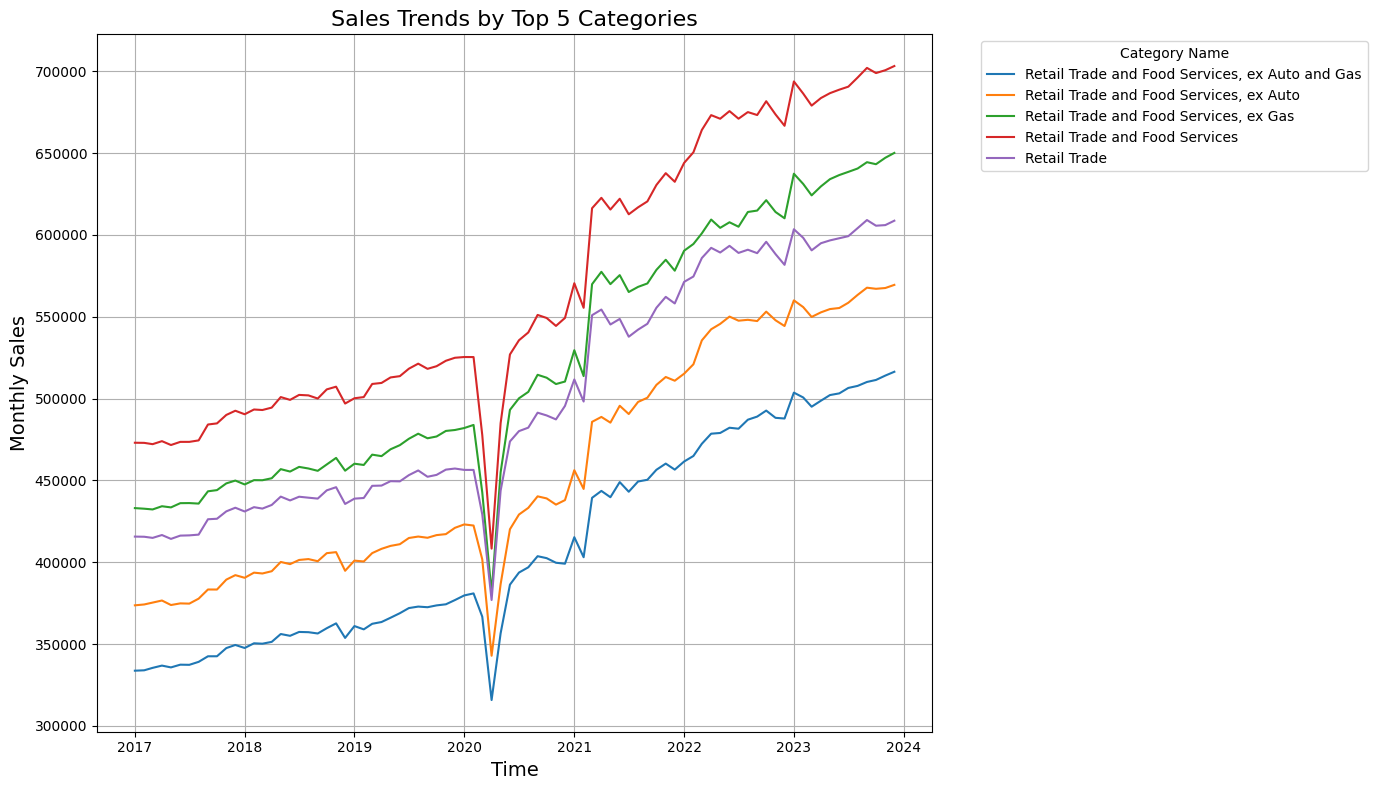

In [24]:
top_categories = sales_avg['category_name'].head(5)
sales_trends_top = sales_trends[sales_trends['category_name'].isin(top_categories)]

plt.figure(figsize=(14, 8))

for category in sales_trends_top['category_name'].unique():
    category_data = sales_trends_top[sales_trends_top['category_name'] == category]
    plt.plot(category_data['time'], category_data['monthly_sales'], label=category)

# Add titles and labels
plt.title('Sales Trends by Top 5 Categories', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True)
plt.tight_layout()

plt.show()


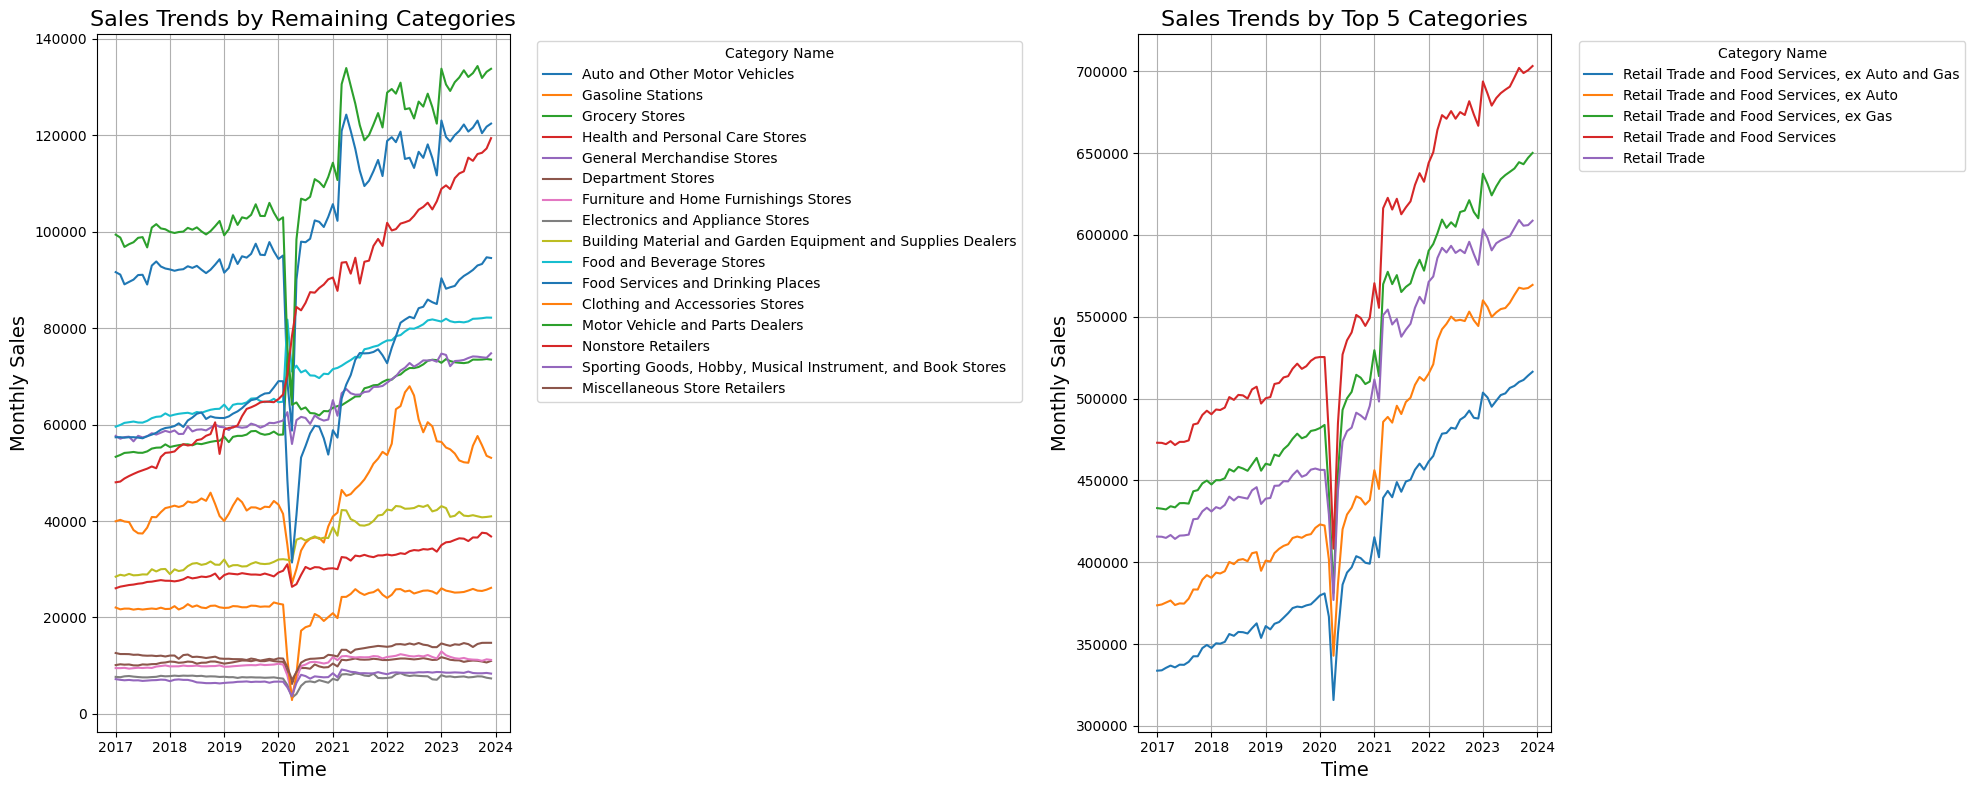

In [25]:
remaining_categories = sales_avg[~sales_avg['category_name'].isin(top_categories)]['category_name']
sales_trends_remaining = sales_trends[sales_trends['category_name'].isin(remaining_categories)]
plt.figure(figsize=(20, 8))

# Categories excluding the top 5
plt.subplot(1, 2, 1)
for category in sales_trends_remaining['category_name'].unique():
    category_data = sales_trends_remaining[sales_trends_remaining['category_name'] == category]
    plt.plot(category_data['time'], category_data['monthly_sales'], label=category)

plt.title('Sales Trends by Remaining Categories', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(visible=True)

# Top 5 categories
plt.subplot(1, 2, 2)
for category in sales_trends_top['category_name'].unique():
    category_data = sales_trends_top[sales_trends_top['category_name'] == category]
    plt.plot(category_data['time'], category_data['monthly_sales'], label=category)

plt.title('Sales Trends by Top 5 Categories', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Monthly Sales', fontsize=14)
plt.legend(title='Category Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(visible=True)

plt.tight_layout()
plt.show()


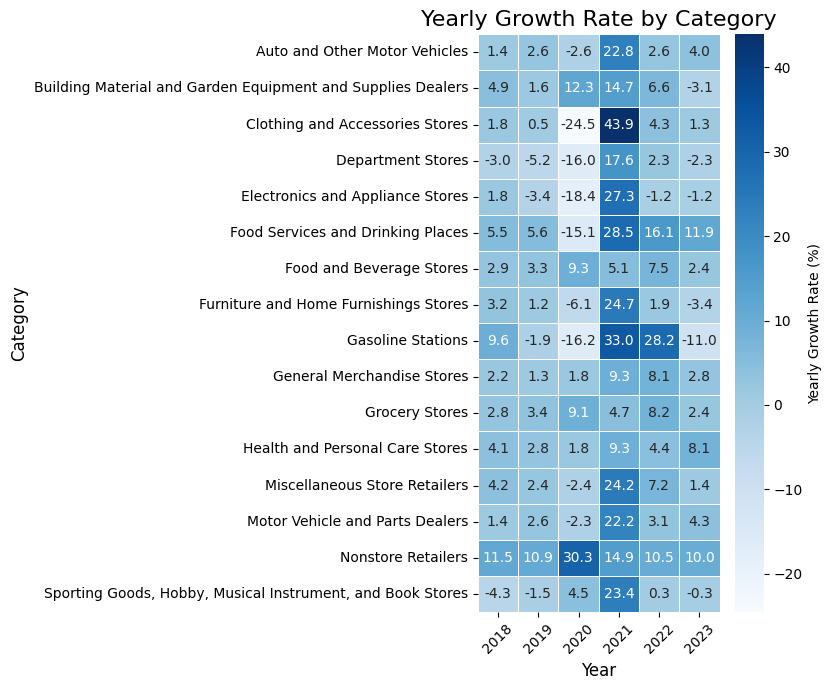

In [26]:
yearly_sales_excluding_top = yearly_sales_sum[yearly_sales_sum['category_name'].isin(remaining_categories)]

heatmap_data_excluding_top = yearly_sales_excluding_top.pivot(
    index='category_name', columns='year', values='yoy_percentage'
)
heatmap_data_excluding_top.drop(columns=2017, inplace=True)
plt.figure(figsize=(8, 7))
sns.heatmap(
    heatmap_data_excluding_top, 
    annot=True, 
    fmt=".1f", 
    cmap='Blues',
    cbar_kws={'label': 'Yearly Growth Rate (%)'}, 
    linewidths=0.5
)
plt.title("Yearly Growth Rate by Category", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
sm_df_not_adjusted

,monthly_sales,category_code,time,category_name,high_level_category
1,6220,451,2017-01-01,"Sporting Goods, Hobby, Musical Instrument, and...",Retail Trade
5,78223,441X,2017-01-01,Auto and Other Motor Vehicles,Retail Trade
7,8408,442,2017-01-01,Furniture and Home Furnishings Stores,Retail Trade
8,52570,4451,2017-01-01,Grocery Stores,Retail Trade
10,25643,446,2017-01-01,Health and Personal Care Stores,Retail Trade
...,...,...,...,...,...
3495,586979,44W72,2023-12-01,"Retail Trade and Food Services, ex Auto and Gas",Retail and Food Services
3496,668957,44000,2023-12-01,Retail Trade,Retail Trade
3497,635671,44Y72,2023-12-01,"Retail Trade and Food Services, ex Auto",Retail and Food Services
3498,11847,442,2023-12-01,Furniture and Home Furnishings Stores,Retail Trade


In [28]:
pivoted_retail = sm_df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Retail Trade']
pivoted_food = sm_df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Food Services and Drinking Places']
pivoted_nonstore = sm_df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Nonstore Retailers']
pivoted_gasoline = sm_df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Gasoline Stations']
pivoted_clothing_and_acc = sm_df_not_adjusted.pivot(index='time', columns='category_name', values='monthly_sales')['Clothing and Accessories Stores']
pivoted_retail

time
2017-01-01    369068
2017-02-01    365596
2017-03-01    423024
2017-04-01    407275
2017-05-01    434531
               ...  
2023-08-01    624457
2023-09-01    589258
2023-10-01    604435
2023-11-01    619189
2023-12-01    668957
Name: Retail Trade, Length: 84, dtype: int64

In [29]:
sns.set_style("whitegrid")

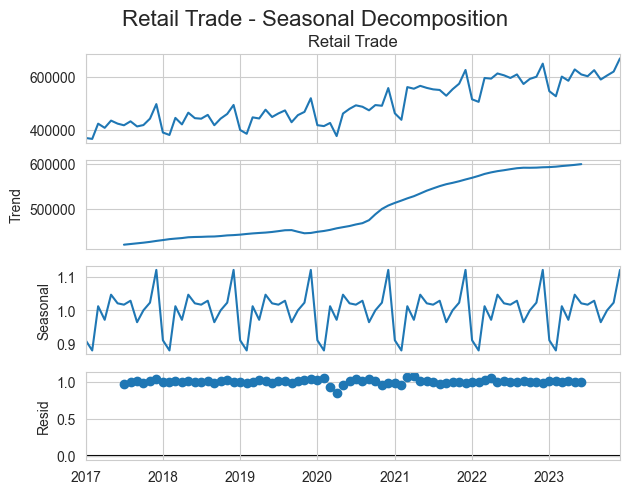

In [44]:
retail_result = seasonal_decompose(pivoted_retail, model='multiplicative', period=12)
retail_result.plot()
plt.suptitle('Retail Trade - Seasonal Decomposition', fontsize=16, y=1.02)
plt.show()

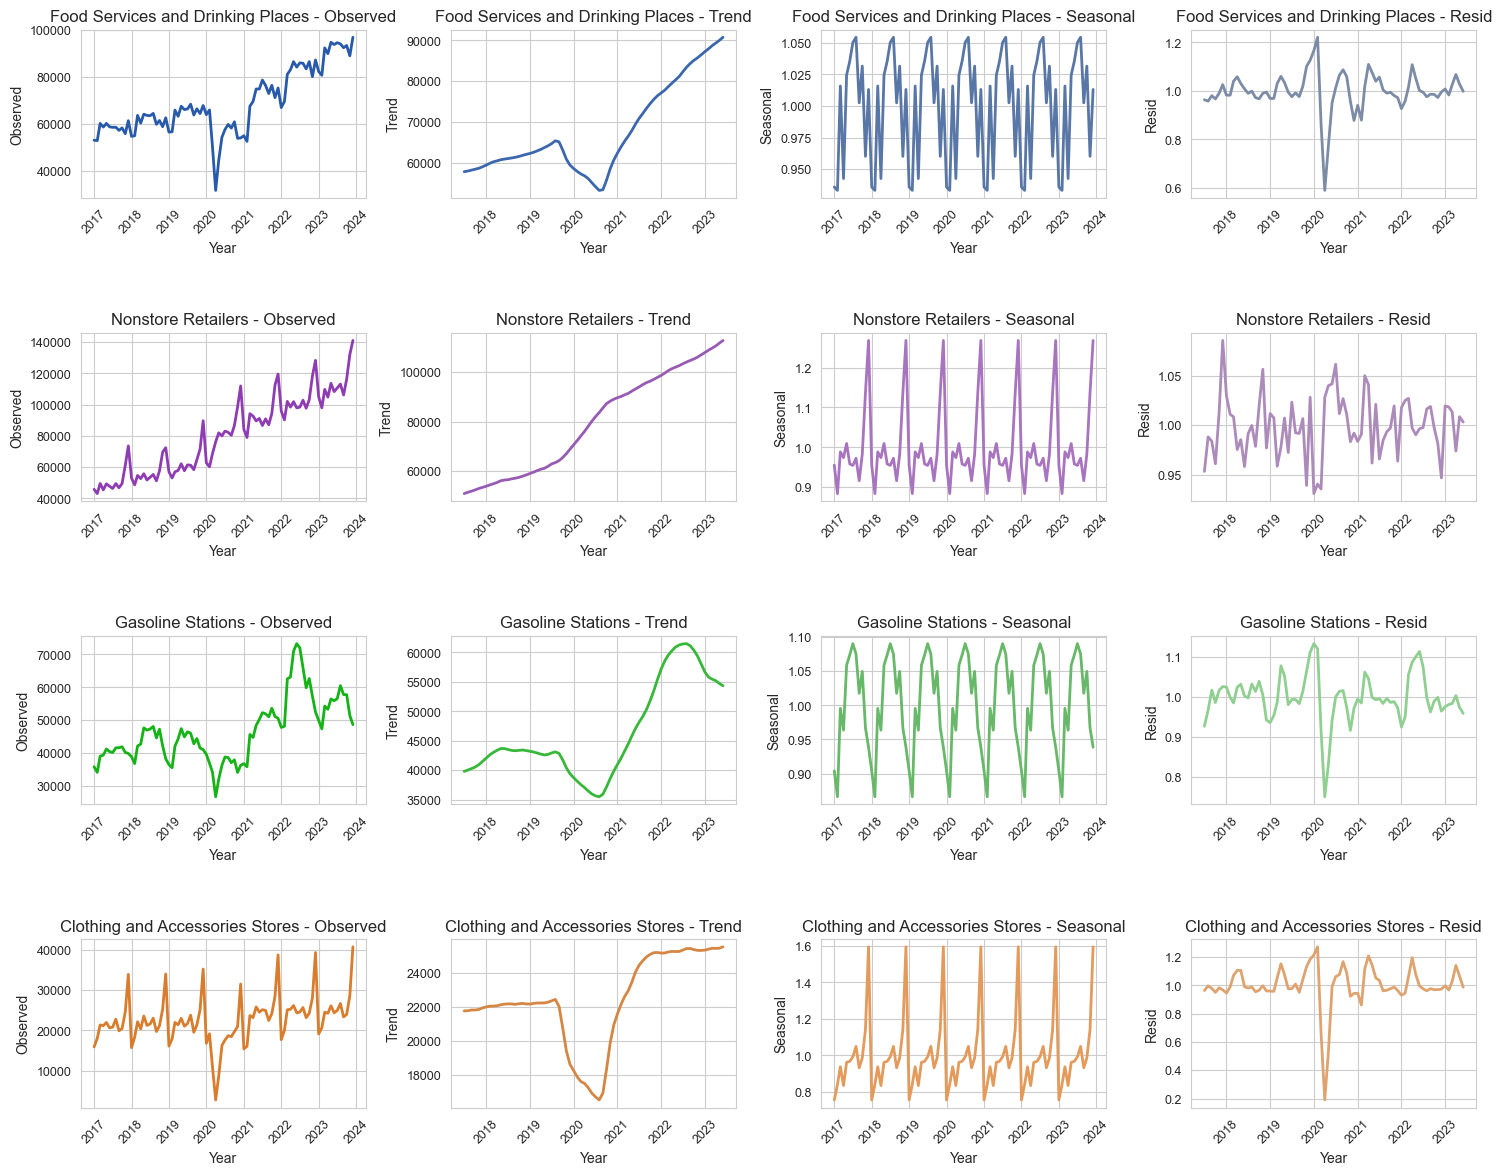

In [43]:
result_food = seasonal_decompose(pivoted_food, model='multiplicative', period=12)
result_nonstore = seasonal_decompose(pivoted_nonstore, model='multiplicative', period=12)
result_gasoline = seasonal_decompose(pivoted_gasoline, model='multiplicative', period=12)
result_clothing = seasonal_decompose(pivoted_clothing_and_acc, model='multiplicative', period=12)

fig, axes = plt.subplots(4, 4, figsize=(18, 14), gridspec_kw={'hspace': 0.8, 'wspace': 0.3})

def plot_components(result, axes, row, category_name):
    components = ['observed', 'trend', 'seasonal', 'resid']
    colors = [["#275aab","#3b67ad","#5876a6","#7c8ca6"],["#8f3bb3","#985bb3","#a873bf","#ac8aba"],["#14b316","#37b839","#67b868","#8fcf90"],["#d97c2b","#d48642","#e39a5b","#dea36f"]]
    for col, component in enumerate(components):
        axes[row, col].plot(getattr(result, component), color=colors[row][col], linewidth=2)
        axes[row, col].set_title(f'{category_name} - {component.capitalize()}', fontsize=12)
        axes[row, col].set_xlabel('Year', fontsize=10)
        axes[row, col].set_ylabel(component.capitalize(), fontsize=10)
        axes[row, col].tick_params(axis='x', rotation=45, labelsize=9)
        axes[row, col].tick_params(axis='y', labelsize=9)

plot_components(result_food, axes, 0, 'Food Services and Drinking Places')
plot_components(result_nonstore, axes, 1, 'Nonstore Retailers')
plot_components(result_gasoline, axes, 2, 'Gasoline Stations')
plot_components(result_clothing, axes, 3, 'Clothing and Accessories Stores')

plt.show()